In [2]:
import os

import numpy as np
import skimage.io
import skimage.transform
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split, KFold

from skimage.morphology import disk, erosion, dilation
from skimage.measure import regionprops, label
import cv2
from PIL import Image

In [3]:
def read_image(path):
    """Reads image from path and returns image array"""
    img = skimage.io.imread(path, as_gray=True)
    img = skimage.transform.resize(img, (800, 800), mode='reflect', anti_aliasing=True, preserve_range=True)
    
    return np.expand_dims(img, axis=2)

def postprocessing(mask):
    '''This function enabels post processing based on binary mask.
    This consists of selecting the largest object (one_object) and a closing
    operation to fill the holes (closing)
    Input: binary mask
    Returns: Post processing mask (0,1)
    ''' 
    labels_mask = label(mask)                       
    regions = regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)
    if len(regions) > 1:
      for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
    labels_mask[labels_mask!=0] = 1
    mask = labels_mask
    
    if np.max(mask) == 255:
      mask = mask/255
    im_flood_fill = mask.copy()
    h, w = mask.shape[:2]
    overlay = np.zeros((h + 2, w + 2), np.uint8)
    im_flood_fill = im_flood_fill.astype("uint8")
    cv2.floodFill(im_flood_fill, overlay, (0, 0), 255)
    im_flood_fill_inv = cv2.bitwise_not(im_flood_fill)
    mask_out = mask | im_flood_fill_inv
    mask_out = mask_out/255
    return mask_out

def overlay(image, mask, color, alpha, resize=None):
    color = color[::-1]
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()

    if resize is not None:
      image = cv2.resize(image.transpose(1, 2, 0), resize)
      image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
    return image_combined

def make_overlay(image, segmentation):
    se = disk(3)
    mask_dil = dilation(np.squeeze(segmentation), se)
    mask_ero = erosion(np.squeeze(segmentation), se)
    mask_border = np.logical_xor(mask_dil,mask_ero)*150
    image_3 = cv2.merge((image, image, image))
    image_with_mask = overlay(image_3, mask_border, color = (0,0,255), alpha=0.33)

    image_with_pred = Image.fromarray((image_with_mask))
    return image_with_pred

def build_unet_model(input_height, input_width, input_channels):
    # Define input layer
    inputs = tf.keras.layers.Input((input_height, input_width, input_channels))

    # Normalize input data
    normalized_inputs = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    # Down sampling path
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(normalized_inputs)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    pool5 = tf.keras.layers.MaxPooling2D((2, 2))(conv5)
    conv6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool5)

    # Upsampling path
    up7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv5])
    conv7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat7)
    up8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = tf.keras.layers.concatenate([up8, conv4])
    conv8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat8)
    up9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = tf.keras.layers.concatenate([up9, conv3])
    conv9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat9)
    up10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv9)
    concat10 = tf.keras.layers.concatenate([up10, conv2])
    conv10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat10)
    up11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv10)
    concat11 = tf.keras.layers.concatenate([up11, conv1], axis=3)
    conv11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat11)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv11)

    # Build the model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model


In [39]:
model = build_unet_model(input_height=800, input_width=800, input_channels=1)
model.load_weights(r"C:\Users\koenk\Documents\Master_Thesis\Programming\Debugging\experiment_009\complete_model_4.h5")

In [40]:
test_image = read_image(r"C:\Users\koenk\Documents\Master_Thesis\Data\Saeedi2017\Images\Blast_PCRM_d5.12.BMP")
# test_image = read_image(r"C:\Users\koenk\Documents\Master_Thesis\Data\BlastsOnline\Images\Blast_PCRM_d5.12.BMP")
# test_image = skimage.transform.rescale(test_image, 3.44/5, mode='reflect', anti_aliasing=True, preserve_range=True)
test_image = skimage.transform.resize(test_image, (800, 800), mode='reflect', anti_aliasing=True, preserve_range=True)
ref_image = read_image(r"C:\Users\koenk\Documents\Master_Thesis\Data\Raw_data\new_data\D2023.12.14_S00168_I4927_P_WELL05\F0\D2023.12.14_S00168_I4927_P_WELL05_RUN573.JPG")

# test_image[test_image>(84 + 131 // 2)] = 84 + 131 // 2
# test_image[test_image<(84 - 131 // 2)] = 84 - 131 // 2

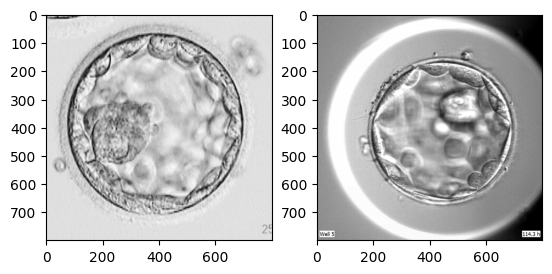

In [41]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(test_image, cmap='gray')
axs[1].imshow(ref_image, cmap='gray')

1/1 [==============================] - 0s 306ms/step


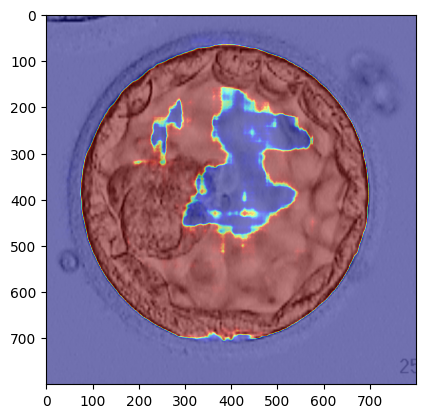

In [42]:
plt.imshow(test_image, cmap='gray')
plt.imshow(model.predict(np.expand_dims(test_image, axis=0))[0,], cmap='jet', alpha=0.5)
plt.show()

In [43]:
IMG_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Data\Saeedi2017\Images/"
MASK_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Data\Saeedi2017\SaeediBinary\Masks/"

test_fn = sorted([file for file in os.listdir(IMG_PATH)])

# Images and timepoints with available masks:
test_images= np.array([read_image(IMG_PATH + file) for file in test_fn], dtype=np.uint8)
test_masks = np.array([read_image(MASK_PATH + file[:-4] + ' ZP_Mask_binary.bmp') for file in test_fn], dtype=bool)

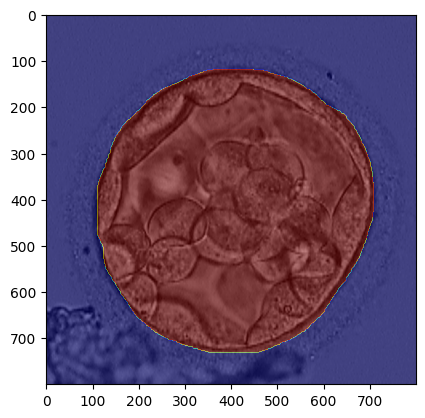

In [44]:
plt.figure()
plt.imshow(test_images[0,], cmap='gray')
plt.imshow(test_masks[0,], cmap='jet', alpha=0.5)
plt.show()

In [45]:
test_image_predictions = model.predict(test_images, batch_size=2)

125/125 [==============================] - 14s 107ms/step


In [46]:
test_image_predictions_thresholded = test_image_predictions > 0.5

In [47]:
from sklearn.metrics import jaccard_score

test_image_predictions_thresholded_postprocessed = np.array([postprocessing(np.squeeze(img)) for img in test_image_predictions_thresholded])

In [48]:
test_jaccard = np.array([jaccard_score(mask.flatten(), mask_t.flatten()) for (mask, mask_t) in zip(test_masks, test_image_predictions_thresholded_postprocessed)])

In [49]:
test_jaccard.mean()

0.9162487106754963

(array([ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         2.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         2.,  4.,  5.,  3.,  6., 16., 23., 77., 83.]),
 array([0.        , 0.00994118, 0.01988235, 0.02982353, 0.03976471,
        0.04970588, 0.05964706, 0.06958824, 0.07952941, 0.08947059,
        0.09941176, 0.10935294, 0.11929412, 0.12923529, 0.13917647,
        0.14911765, 0.15905882, 0.169     , 0.17894118, 0.18888235,
        0.19882353, 0.20876471, 0.21870588, 0.22864706, 0.23858824,
        0.24852941, 0.25847059, 0.26841176, 0.27835294, 0.28829412,
        0.29823529, 0.3081

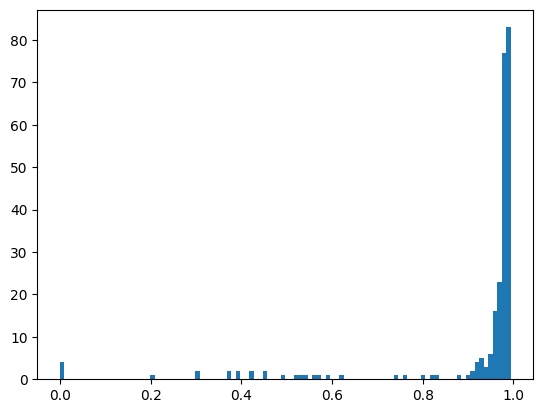

In [50]:
plt.hist(test_jaccard, bins=100)

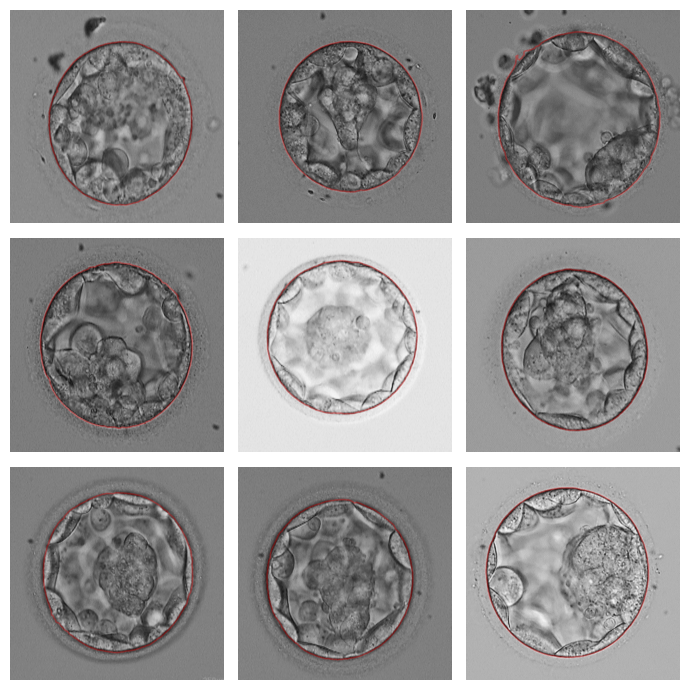

In [51]:
# plot 5 examples of masksk with test_jaccard > 0.9:
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
for i, index in enumerate(np.where(test_jaccard > 0.98)[0][:9]):
    axs[i//3, i%3].imshow(make_overlay(np.squeeze(test_images[index,]), np.squeeze(test_image_predictions_thresholded_postprocessed[index,])))
    axs[i//3, i%3].axis('off')
plt.tight_layout()
plt.show()

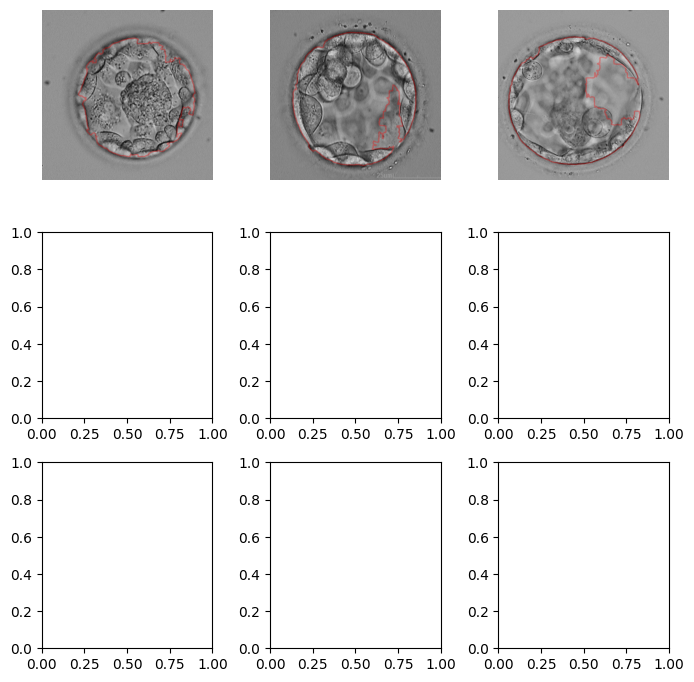

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
for i, index in enumerate(np.where((test_jaccard > 0.8) & (test_jaccard < 0.9))[0][:9]):
    axs[i//3, i%3].imshow(make_overlay(np.squeeze(test_images[index,]), np.squeeze(test_image_predictions_thresholded_postprocessed[index,])))
    axs[i//3, i%3].axis('off')
plt.tight_layout()
plt.show()

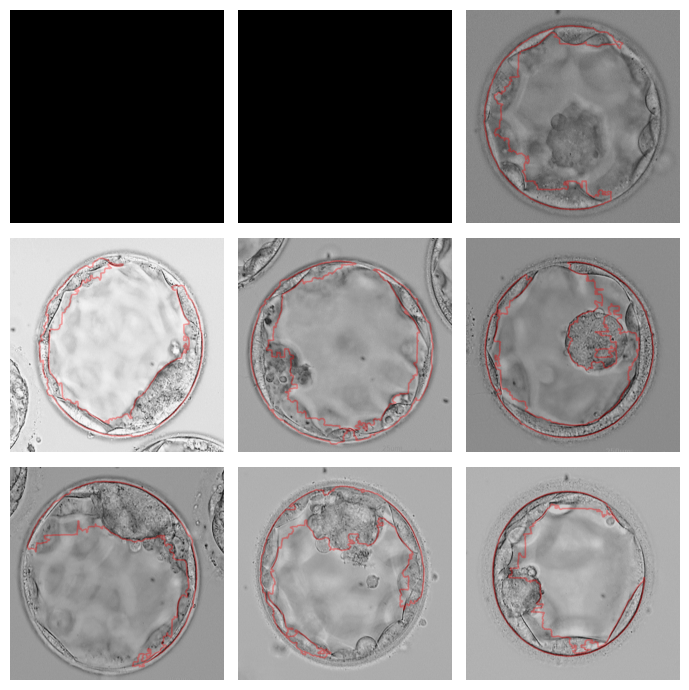

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
for i, index in enumerate(np.where(test_jaccard < 0.40)[0][:9]):
    axs[i//3, i%3].imshow(make_overlay(np.squeeze(test_images[index,]), np.squeeze(test_image_predictions_thresholded_postprocessed[index,])))
    axs[i//3, i%3].axis('off')
plt.tight_layout()
plt.show()

In [37]:
test_fn[241]

'Blast_PCRM_d5.2 left.BMP'

In [25]:
np.where(test_jaccard < 0.10)[0][:9]

array([ 12,  13, 241, 242], dtype=int64)

In [29]:
np.where(test_jaccard > 0.9)[0].shape

(222,)

In [21]:
test_image_predictions_thresholded_postprocessed.dtype

dtype('float64')

In [ ]:
# Albumentations histogram matching?

In [22]:
IMG_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Data\transfer_2199042_files_77f351f0\image\image/"
FOLDS = [
    (np.arange(1,12), np.arange(12,17), np.arange(18,23)),
    (np.arange(6,17), np.arange(18,23), np.arange(1,6)),
    (np.arange(12,23), np.arange(1,6), np.arange(6,12)),
    (np.append(np.arange(1,6),np.arange(18,23)), np.arange(6,12), np.arange(12,17))
    ]

In [23]:
train_ids, val_ids, test_ids = FOLDS[0]
train_fn = sorted([file for file in os.listdir(IMG_PATH) if int(file.split('_')[0][1:]) in train_ids])
train_images = np.array([read_image(IMG_PATH + file) for file in train_fn], dtype=np.uint8)

In [24]:
mean_train, std_train = np.mean(train_images), np.std(train_images)
mean_new, std_new = np.mean(test_images), np.std(test_images)

test_images_rescaled = ( (test_images - mean_new) / std_new ) * std_train + mean_train

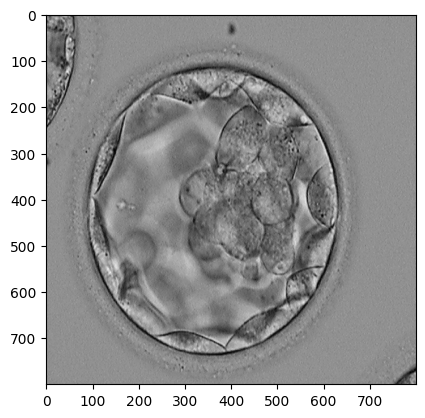

In [25]:
plt.imshow(test_images[181,], cmap='gray')

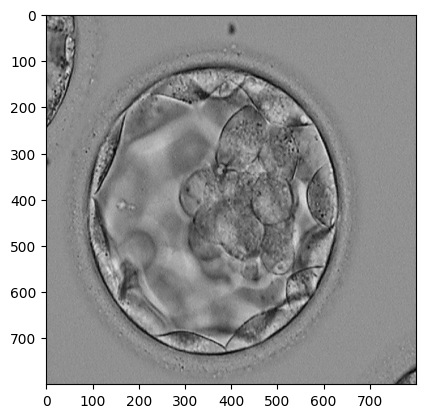

In [26]:
plt.imshow(test_images_rescaled[181,], cmap='gray')

In [27]:
test_images_rescaled[181,].std()

28.664634560471452

In [28]:
test_images[181,].std()

16.331111671328333

In [29]:
pred = model.predict(test_images_rescaled[181,].reshape(1, 800, 800, 1))

1/1 [==============================] - 0s 66ms/step


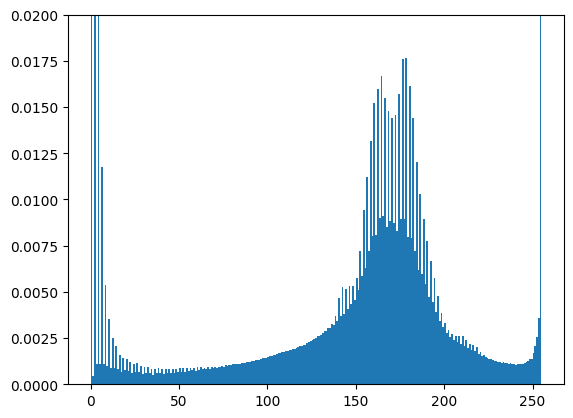

In [30]:
plt.hist(train_images.flatten(), bins=255, density=True)
plt.ylim([0, 0.02])
plt.show()

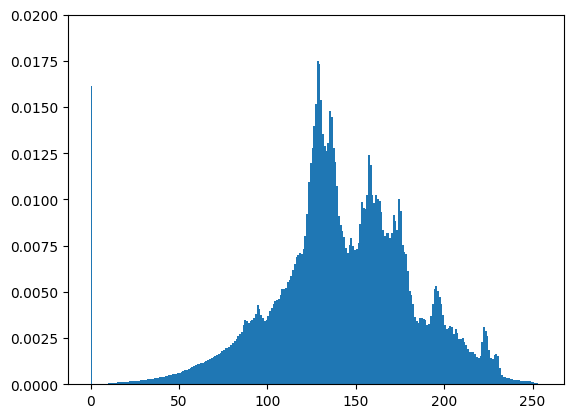

In [31]:
plt.hist(test_images.flatten(), bins=255, density=True)
plt.ylim([0, 0.02])
plt.show()

In [32]:
from skimage.exposure import match_histograms

matched = match_histograms(test_images[181,], train_images[16,],)

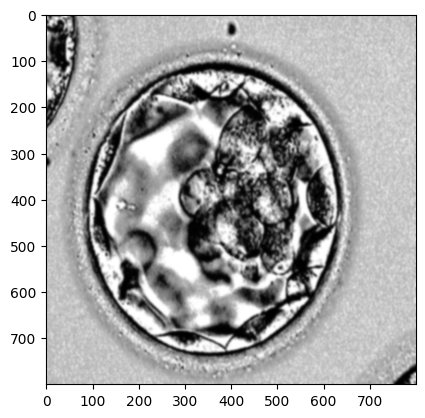

In [48]:
plt.imshow(skimage.filters.gaussian(matched, sigma=2), cmap='gray')

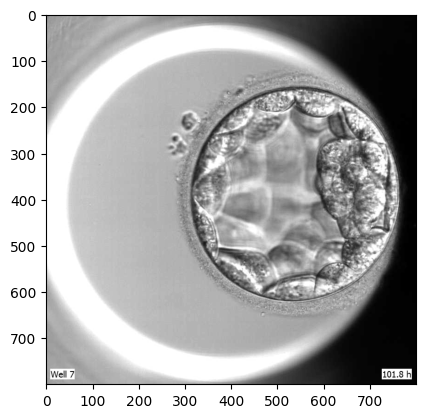

In [34]:
plt.imshow(train_images[16,], cmap='gray')

1/1 [==============================] - 0s 40ms/step


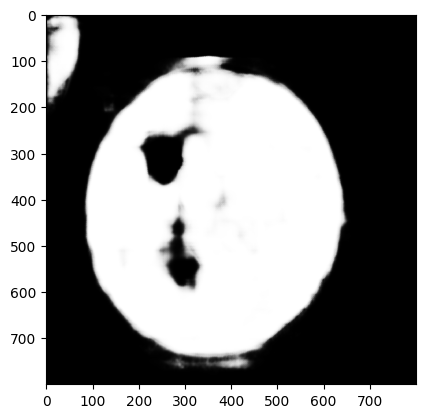

In [35]:
pred = model.predict(skimage.filters.gaussian(matched, sigma=2).reshape(1, 800, 800, 1))
plt.imshow(pred[0,], cmap='gray')

In [36]:
np.squeeze(test_images[0]).shape

(800, 800)

In [37]:
test_images_matched = np.expand_dims(np.array([match_histograms(np.squeeze(img), np.squeeze(train_images[16,])) for img in test_images]), axis=-1)
test_images_matched = np.expand_dims(np.array([skimage.filters.gaussian(np.squeeze(img), sigma=2) for img in test_images_matched]), axis=-1)

In [38]:
test_image_predictions_matched = model.predict(test_images_matched, batch_size=1)

test_image_predictions_thresholded_matched = test_image_predictions_matched > 0.5

249/249 [==============================] - 13s 50ms/step


In [39]:
test_image_predictions_thresholded_postprocessed_matched = np.array([postprocessing(np.squeeze(img)) for img in test_image_predictions_thresholded_matched])

In [40]:
test_jaccard = np.array([jaccard_score(mask.flatten(), mask_t.flatten()) for (mask, mask_t) in zip(test_masks, test_image_predictions_thresholded_postprocessed_matched)])

In [41]:
test_jaccard.mean()

0.8794670578028623

In [42]:
test_images_matched.shape

(249, 800, 800, 1)

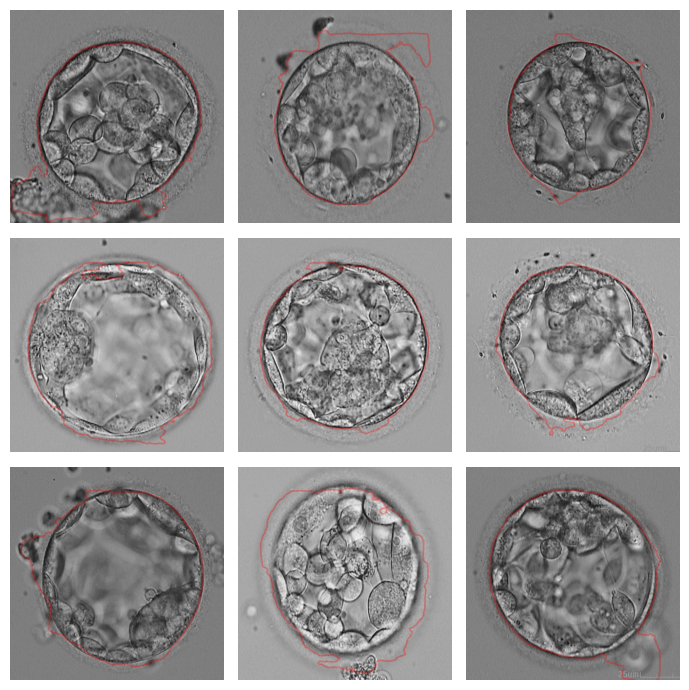

In [46]:
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
for i, index in enumerate(np.where(test_jaccard < 70)[0][:9]):
    axs[i//3, i%3].imshow(make_overlay(np.squeeze(test_images[index,]), np.squeeze(test_image_predictions_thresholded_postprocessed_matched[index,])))
    axs[i//3, i%3].axis('off')
plt.tight_layout()
plt.show()